# 비지도 학습


## 목차

- 군집

  - K-mean

  - 군집을 사용한 이미지 분할

  - 군집을 사용한 전처리

  - 군집을 사용한 준지도 학습

  - DBSCAN

- 가우시안 혼합

  - 가우시안 혼합을 사용한 이상치 탐지

  - 클러스터 개수 선택하기

  - 베이즈 가우시안 혼합 모델


## 군집


비슷한 샘플을 구별해 하나의 군집(cluster) 또는 비슷한 샘플 그룹으로 할당하는 것을 **군집화(clustering)**이라 부른다.

정상 데이터의 형상을 토대로 이상치를 탐지하는 것에 주로 사용된다.


## K-means


K-means(로이드-포지 알고리즘이라고도 불른다)는 작은 수의 반복으로도 데이터를 빠르고 효율적으로 군집화 할 수 있는 알고리즘이다.

각 군집의 중심(센트로이드)을 찾고 결정경계를 형성하여 가장 가까운 군집에 샘플을 할당하는 방식으로 동작한다.


In [1]:
# Load data
from sklearn.datasets import make_blobs
import numpy as np

blob_centers = np.array(
    [[0.2,  2.3],
     [-1.5,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

### Code: k-means


In [3]:
from sklearn.cluster import KMeans

k = 5  # n_clusters를 통해 군집의 개수를 선택할 수 있다.
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

# 클러스터의 중심
print(kmeans.cluster_centers_)

# 예측값 군집 출력
kmeans.predict(np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]]))

[[-2.80389616  1.80117999]
 [ 0.20876306  2.25551336]
 [-2.79290307  2.79641063]
 [-1.46679593  2.28585348]
 [-2.80037642  1.30082566]]


array([1, 1, 2, 2], dtype=int32)

위와 같이 생성된 K-means는 그래프를 통해 결정경계를 아래와 같이 확인할 수 있다.

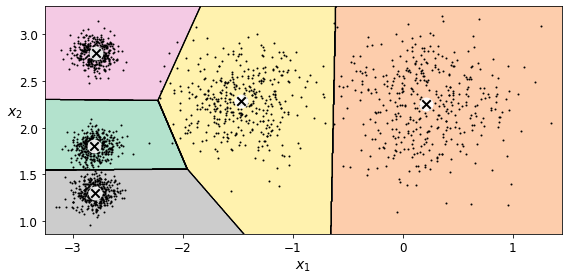


### K-means 알고리즘


K-means 알고리즘의 동작 방법은 아래와 같다.

1. 무작위로 센트로이드를 설정

2. 각 샘플을 가장 가까운 센트로이드에 할당한다.

3. 군집별로 중심과 샘플간의 유클리드 거리 평균을 계산해서 센트로이드를 업데이트 한다.

군집 중심과 샘플간의 거리의 평균이 작을수록 좋은 구집이라고 할 수 있다. 이를 위해 K-means의 목적은 군집 내의 제곱 거리 합을 최소화하는 것이며 이를 평가하는 손실함수를 **이너셔(inertia)** 라고 한다.

> 이니셔는 kmeans.inertia\_와 같이 확인할 수 있으며 모두 음수값을 가진다. sklearn의 score 메소드는 항상 "큰 값이 좋은 값으로 평가" 하기 때문에 음수값을 취하여 작을수록 좋은 값으로 평가하도록 한다.

<br>

현재 sklearn에서 제공하는 알고리즘은 최적화가 이루어진 알고리즘으로 초기 K-means 방법을 수행하기 위해 init="randome", n_init=1, algorithm="full" 옵션을 설정한다.

이후 최대 반복 횟수인 max_iter 값을 변화하며 군집의 중심의 변화를 확인해보자.(random_state값이 0으로 항상 동일하기에 최초에 랜덤으로 배치되는 군집 중심은 항상 동일하다.)


In [5]:
kmeans = []
for i in range(1, 4, 1):
    kmeans.append(KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", max_iter=i, random_state=0))
    kmeans[i-1].fit(X)

/Users/jaewone/ENTER/envs/tf25/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1316: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/Users/jaewone/ENTER/envs/tf25/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1316: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/Users/jaewone/ENTER/envs/tf25/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1316: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


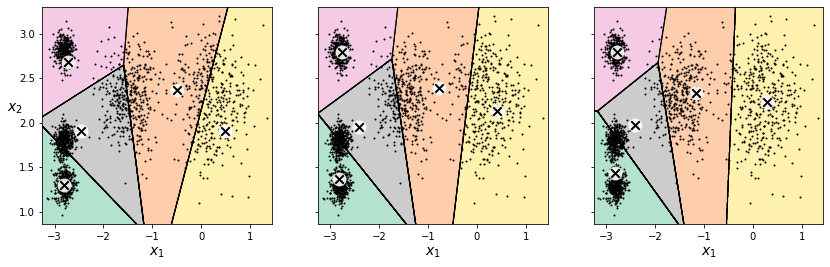

In [11]:
# show on graph
import matplotlib.pyplot as plt


def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)


def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)


def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                 cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


# show 3 kmeans plot
plt.figure(figsize=(14, 4))
plt.subplot(131)
plot_decision_boundaries(kmeans[0], X)
plt.subplot(132)
plot_decision_boundaries(kmeans[1], X, show_ylabels=False)
plt.subplot(133)
plot_decision_boundaries(kmeans[2], X, show_ylabels=False)
plt.show()

그래프를 그려 결과를 확인해보았을 때 군집 중심이 점차 데이터가 밀집한 곳으로 이동함을 확인할 수 있다.


### 하드 군집과 소프트 군집


샘플을 할당하는 방법에 따라 하드 군집과 소프트 군집으로 구분된다.

- **하드 군집**: 각 샘플에 대해 가장 가까운 클러스터를 선택한다.

- **소프트 군집**: 샘플마다 모든 클러스터에 대해 거리를 측정하고 가까운 클러스터에 할당하되, 거리가 가까운 클러스터에 높은 가중치를 부여한다.


### K-means 알고리즘


#### 좋은 모델 선택법


K-means는 기본적으로 각 샘플의 중심간의 거리 제곱의 합인 **이너셔**를 최소화하는 방향으로 학습이 진행된다.

이외 다양한 초기화 과정을 실험한 뒤 가장 작은 이너셔 값을 가지는 모델을 선택하는 방법도 있다. 이를 좋은 모델 선택법이라 부른다.

n_init을 통해 초기화하는 횟수를 지정할 수 있다. n_init = 10 일 경우 10번 K-means를 초기화 한 뒤 이너셔가 가장 작은 모델을 선택함을 의미한다.


In [ ]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(X)

#### K-means++


센트로이드를 무작위로 초기화하는 대신 특정 확률분포를 사용하여 초기화하는 방법을 **K-means++** 라고 부른다. init 옵션을 통해 알고리즘을 선택할 수 있으며 KMeans의 디폴트 알고리즘이다.


#### elkan 알고리즘


삼각부등식을 통해 불필요한 거리 계산을 피함으로써 학습 속도를 향상시킨 알고리즘을 elkan이라고 부른다.

elkan 알고리즘은 밀집벡터에 대해 잘 작동하나 희소행렬에 대해서는 동작하지 않는다. 따라서 희소행렬의 경우 'full' 알고리즘에 의해 계산한다.


In [ ]:
KMeans(algorithm="elkan", random_state=42).fit(X)

### 미니배치


미니배치를 사용하여 학습을 더 빠르게 수행할 수 있다. 데이터가 클수록 더 빠르게 동작한다.


In [ ]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

### 최적의 군집 수


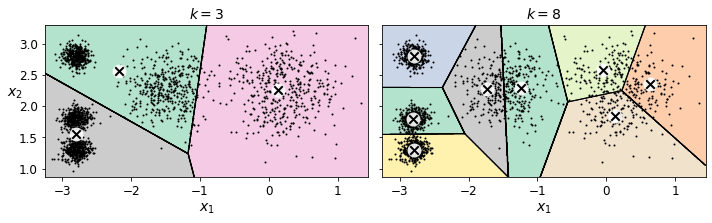


위와 같이 지나치게 적거나 많은 군집수는 분류를 수행함에 있어 악영향을 미친다. 따라서 적절한 군집 수를 결정하는 것이 중요하다.


#### 엘보우 방법


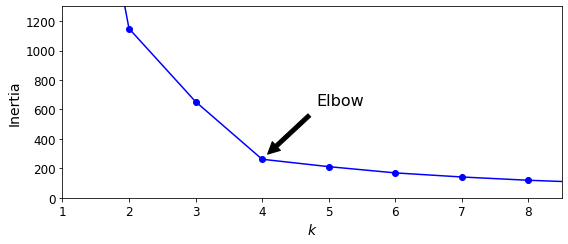


클러스터 개수 k가 증가할수록 센트로이드와 샘플간의 거리 총합인 이너셔가 감소한다. 따라서 이너셔가 감소하는 지점인 팔꿈치가 최적의 클러스터 개수 k로 선택하는 방법이 엘보우 방법이다.

하지만 관성만으로는 모델을 평가하기에 부족하다.


#### 실루엣 점수


같은 클러스터에 있는 다른 샘플까지의 평균 거리를 클러스터 내부 평균 거리라고 부른다.

실루엣 점수란 모든 샘플에 대한 실루엣 계수의 평균이다. 실루엣 계수는 -1에서 1사이의 값을 가진다.

- 1에 가까우면 샘플이 다른 클러스터로부터 떨어져 자신의 클러스터 안에 잘 있다는 것을 의미한다.

- 0에 가까우면 클러스터 경계에 가깝다는 의미이다.

- -1에 가까우면 샘플이 잘못된 클러스터에 할당되었을지 모른다는 것을 의미한다.

<br>

실루엣 점수를 계산 수식은 아래와 같다.

$$(b-a) / max(b, a)$$

이때 a는 같은 클러스터에 있는 다른 샘플까지의 평균 거리이고, b는 가장 가까운 클러스터까지 평균 거리이다. 즉 가장 가까운 클러스터(샘플 자신의 클러스터를 제외하고)를 최소화하는 클러스터의 샘플까지 평균 거리이다.

예를 들어 아래와 같이 k값에 따른 실루엣 점수를 계산하면 k=4일 때 가장 높은 실루엣 점수를 얻을 수 있다.


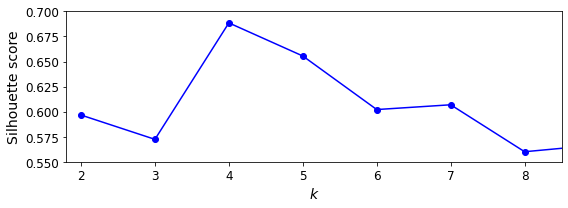


아래와 같이 모든 샘플의 실루엣 계수를 할당된 클러스터와 실루엣 값으로 정렬하여 **실루엣 다이어그램**을 그릴 수 있다.


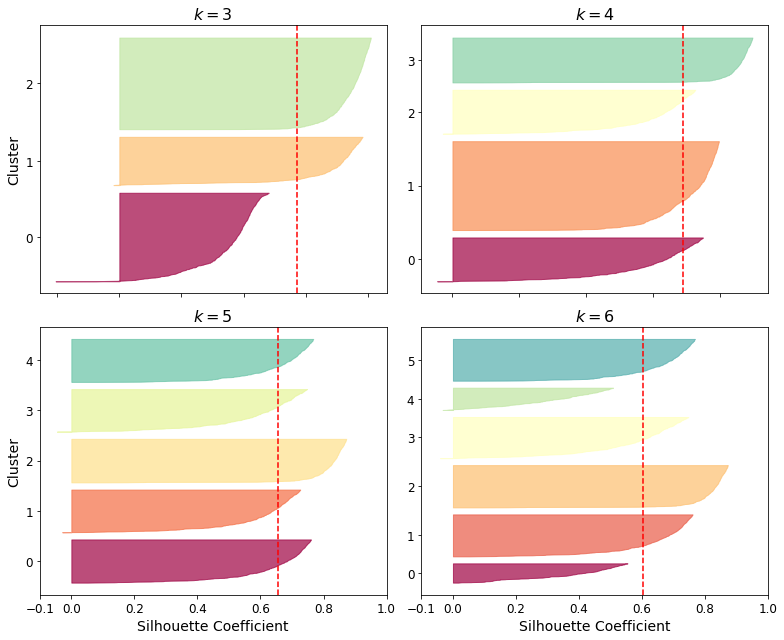


주로 칼 모양의 그래프를 보이며 칼의 두께는 클러스에 포함된 샘플의 개수를, 칼의 길이는 클러스터에 포함된 샘플의 실루엣 계수이다.

즉 칼의 두께가 균등하게 분포되어 있고, 칼의 길이가 길수록 좋은 클러스터라고 볼 수 있다. 이 관점에서 k=5일 때 가장 좋은 클러스터라고 볼 수 있다.

> 붉은색 파선은 클러스터 계수에 해당하는 실루엣 점수이다. 대부분의 칼의 길이가 붉은색 파선보다 길어야 좋다. 붉은색 파선보다 작을 경우 다른 클러스터와 지나치게 가까움을 의미한다.


### K-means 한계


K-means는 다음과 같은 한계가 있다.

- 클러스터의 개수를 미리 지정해야 한다.

- 클러스터의 크기나 밀집도가 다르거나, 원형이 아닌 클러스터를 잘 구분하지 못한다.

- 최적의 클러스터를 찾기 위해 알고리즘을 여러 번 실행해야 한다.


### K-means 전처리


K-means를 이용해 차원을 축소하여 모델의 성능을 향상시킬 수 있다.


In [13]:
# Load dataset
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X_digits, y_digits, random_state=42)

In [14]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.9688888888888889

위와 같이 일반적인 로지스틱 회귀를 통해 8x8 크기의 이미지를 분류할 때 96%의 성능을 보인다.

이때 K-means를 통해 64차원(8x8)을 50차원으로 축소한 뒤 이미지를 분류하면 97%의 성능을 보임을 확인할 수 있다.


In [15]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr",
     solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.9777777777777777

### K-means 준지도 학습


일상 생활에서 얻는 데이터는 대부분 라벨이 존재하지 않는다. 이에 지도학습을 수행하기 위해 라벨링 작업을 진행해야 하는데 이는 많은 비용이 들어간다.

이에 군집화를 통해 센터라이즈에 가장 가까운 데이터 n개를 선정하고, 이를 라벨링하여 지도학습을 수행할 수 있다. 센터라이즈에 가까운 데이터 들은 해당 군집을 대표하기에 라벨링하고자 하는 데이터의 특징을 대표할 가능성이 크기 때문이다.


In [17]:
# 먼저 일반적인 로지스틱 모델의 예측 확률을 살펴보자.
n_labeled = 50
log_reg = LogisticRegression(
    multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

In [16]:
k = 50

# K-means를 학습한 뒤 군집 중심에서 가장 가까운 샘플 50개를 선정한다.
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

# 선정된 X_representative_digits에 대하여 직접 라벨링한 뒤
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 1, 8, 6,
    3, 1, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 7, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9])

# 로지스틱 모델의 학습 데이터로서 사용한다.
log_reg = LogisticRegression(
    multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.09555555555555556

### DBSCAN


밀집된 연속적 지역을 클러스터로 정의하는 것이다. 이는 입실론 반경 내에 존재하는 이웃의 수를 통해 연속적 지역을 정의함으로 클러스터의 개수를 미리 지정할 필요가 없다.

KNN과 유사한 개념으로 이를 위해 두 개의 하이퍼파라미터를 사용한다.

- eps: 입실론 반경으로 반경이다.

- min_samples: 입실론 반경 내에 존재하는 이웃의 수이다.

DBSCAN은 입실론 반경 내에서 자신을 포함해서 min_samples개의 이웃을 갖는 샘플인 **핵심 샘플**을 구한 뒤 핵심샘플들을 연결하는 방식으로 클러스터를 구성한다.

> 핵심 샘플이거나 핵심 샘플의 이웃이 아닌 샘플은 이상치로 간주한다.


In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

아래와 같이 인접한 데이터들을 통해 군집을 형성함을 확인할 수 있다.


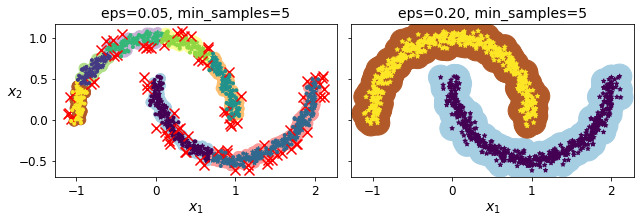


DBSCAN은 군집 모양과 개수에 영향을 받지 않으며 이상치에 안정적이라는 장점을 가지고 있으나 군집 간의 밀집도가 크게 다르면 모든 군집을 파악하기 불가능하다는 단점이 있다.

$O(m\,\times log\,m)$(m은 샘플 수)로 거이 샘플 수에 대하여 선형적으로 복잡도가 증가한다. 하지만 $O(m^2)$의 큰 공간복잡도를 가진다.


## 가우시안 혼합


하나의 가우시안 분포에서 생성된 모든 샘플들의 그룹을 **클러스터(cluster)** 라고 하며 일반적으로 타원형 모양의 분포를 이룬다.

<img src="https://kr.mathworks.com/help/examples/stats/win64/ViewGaussianMixtureModelsOverComponentLevelsExample_01.png">


이에 샘플이 파라미터가 알려지지 않은 여러 개의 혼합된 가우시안 분포에서 생성되었다고 가정하고, 각 클러스터가 어떤 가우시안 분포를 따르는지, 그리고 각 클러스터에 속할 확률은 얼마인지를 추정하는 방법이 **가우시안 혼합 모델(Gaussian Mixture Model, GMM)** 이다.

<br>

sklearn에서 GaussianMixture를 사용하여 가우시안 혼합 모델을 구현할 수 있다.

n_components를 통해 군집 수를 지정하며, n_init는 초기화 횟수를 의미한다. n_init만큼 초기화를 반복하여 가장 좋은 결과를 반환한다.


In [ ]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3,   # 군집의 개수
                     n_init=10,        # 초기화 실행 횟수
                     random_state=42)
gm.fit(X)

gm.weights_  # 각 군집의 비율
gm.means_  # 각 군집의 중심
gm.covariances_  # 각 군집의 공분산 행렬

학습된 모델을 시각적으로 내타낼 경우 다음과 같이 시각화할 수 있다.

붉은색 점선은 결정 경계를 믜미하며 등고선은 확률 밀도를 나타낸다.

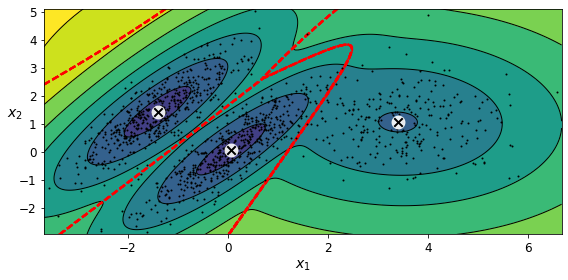


이와 같은 GMM은 공분산에 규제를 가하여 학습을 도와줄 수 있다. 이를 위해 `covariance_type` 인수를 사용한다.

- `covariance_type='full'`: 기본값, 공분산 행렬의 모든 원소를 학습하여 어떤 크기의 타원도 될 수 있다.

- `covariance_type='diag'`: 클래스별로 독립적인 대각 공분산 행렬을 가진다고 가정한다. 즉, 모든 클래스가 타원형으로 군집을 구성하지만 타원의 축이 좌표축과 평행하다고 가정한다.

- `covariance_type='spherical'`: 클래스별로 독립적인 원형 공분산 행렬을 가진다고 가정한다. 즉, 모든 클래스가 서로 다른 크기의 원형으로 군집을 구성한다.

- `covariance_type='tied'`: 모든 클래스가 공통으로 하나의 공분산 행렬을 가진다고 가정한다. 즉, 모든 군집의 동일 모양, 동일 크기, 동일 방향을 갖는다고 가정한다.

<img src="https://user-images.githubusercontent.com/449558/37855461-c6a28060-2ec5-11e8-95ab-d19039350161.png">


### GMM 이상치 탐지


GMM은 밀도가 임곗값보다 낮은 지역에 있는 샘플을 파악하는 방법으로 이상치 탐지에 많이 사용된다.

이때 임곗값이 너무 높으면 거짓 양성 비율이 높아지고, 임곗값이 너무 낮으면 거짓 음성 비율이 높아진다.

score_samples() 메서드를 사용하여 각 샘플의 이상치 점수를 얻을 수 있다. 이 점수는 샘플이 속한 군집의 밀도의 로그를 반환한다.


In [ ]:
# 각 샘플의 군집에 대한 확률을 계산한다.
densities = gm.score_samples(X)

# 이상치의 확률이 4% 미만인 샘플을 모두 찾는다.
density_threshold = np.percentile(densities, 4)

# 이상치만을 선택한다.
anomalies = X[densities < density_threshold]

이상치인 anomalous 값들을 붉은색 점들로 표시하면 아래와 같다. 밀도가 낮은 지역에 분포되어 있는 값들이 이상치로 간주된 것을 확인 할 수 있다.

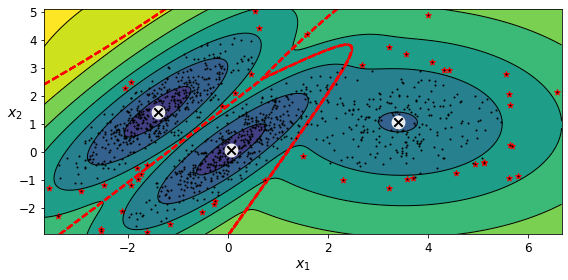


### GMM 클러스터 개수 선택


데이터에 대한 사전 정보가 부족할 경우 클러스터 개수를 정의하는 것에 어려움이 있을 수 있다.

하지만 K-means에서 사용하였던 실루엣 점수를 이용할 수는 없다. 군집이 타원형일 때 값이 일정하지 않기 때문이다.

이에 학습할 파라미터가 많은 모델에 벌칙을 가하고 데이터에 잘 학습하는 모델에 보상을 가하는 AIC, BIC 알고리즘을 통해 클러스터 개수에 따른 값을 계산할 수 있다. 가장 작은 AIC, BIC 값을 가지는 클러스터가 최적의 클러스터 개수라고 할 수 있다.

아래 그래프의 경우 최적의 클러스터 개수는 3개이다.

<img src="https://raw.githubusercontent.com/jaewonE/muchine_learning_notebook/main/codes/images/end_to_end_project/AIC-and-BIC-values-for-the-two-dimensional-GMM-analysis-as-a-function-of-logdensity.png">


이때 클러스터 개수가 증가할수록 AIC, BIC 값이 감소할 수도 있다. 하지만 클러스터 개수가 증가할수록 모델이 복잡해지고, 과적합이 이루어 질 수 있기에 적절한 클러스터 개수를 선택해야 한다.

아래 그래프의 경우 최적의 클러스터 개수는 10개이다.

<img src="https://raw.githubusercontent.com/jaewonE/muchine_learning_notebook/main/codes/images/end_to_end_project/AIC-and-BIC-score-for-Multi-Dimensional-DBSCAN-GMM-model.png">


sklearn의 BayesianGaussianMixture를 통해 최적의 군집수를 탐색할 수 있다. 이때 n_components의 값은 최대 군집수를 제공해야 한다. n_components개의 군집 중에서 자동으로 불필요한 군집을 제거하여 최적의 군집수를 찾아준다.


In [ ]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10,  # 최대 군집의 개수
                              n_init=10,       # 초기화 실행 횟수
                              random_state=42)
bgm.fit(X)

이와 같은 GMM은 타원형 클러스터에 대해 잘 동작한다.

하지만 타원형이 아닌 클러스터에 대해서는 잘 동작하지 않는다. 예를 들어 Moon dataset에 대해서는 잘 동작하지 않는다. 타원형 데이터가 아님에도 억지로 타원을 찾으려고 시도하여 2개가 아닌 8개의 클러스터를 찾아내는 모습을 보인다.

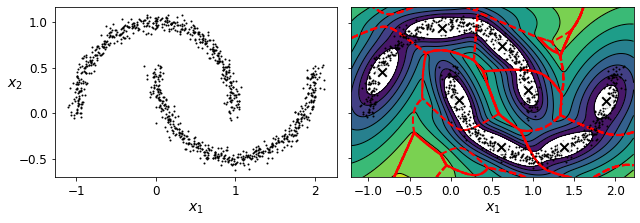
